In [38]:
import pandas as pd
import numpy as np

df = pd.read_csv('table-14.csv')

# drop the file headers
df = df.drop(range(9))

# reassign first row of data frame (df.iloc[0]) to be the column headers
df.columns = df.iloc[0] 

# reset the index column for the dataframe
df = df[1:].reset_index(drop=True) 

# drop unnecessary columns
df = df.drop(columns=['Financial year end', 'Year End Month']) 

# remove any rows where the Value column is NaN
df = df.dropna(subset=['Value (Ratio)']) 

# Negative values are shown in parentheses. Convert these to standard negative
# number notation to avoid errors.
df['Value (Ratio)'] = df['Value (Ratio)'].str.replace('(','-')
df['Value (Ratio)'] = df['Value (Ratio)'].str.replace(')','')

# remove duplicate rows
df = df.drop_duplicates() 

# convert KFI values to number format:

# Identify non-numeric values before coercion
original_values = df['Value (Ratio)']
numeric_values = pd.to_numeric(original_values, errors='coerce')

# Find rows where conversion to numeric failed (became NaN) and the original was not already NaN or an empty string
conversion_errors = df[numeric_values.isna() & original_values.notna() & (original_values != '')]

if not conversion_errors.empty:
    print('The following original entries in "Value (Ratio)" caused conversion errors and will be set to NaN:')
    display(conversion_errors[['KFI ratio title', 'Value (Ratio)']])
else:
    print('No non-numeric conversion errors found in "Value (Ratio)".')

# Convert 'Value (Ratio)' to numeric, coercing errors
df['Value (Ratio)'] = numeric_values 

# Drop rows where 'Value (Ratio)' became NaN after conversion
df.dropna(subset=['Value (Ratio)'], inplace=True) 

df["Value (Ratio)"] = pd.to_numeric(df["Value (Ratio)"], errors='coerce')

# convert % values to decimals for Tableau / other processing

# Create a boolean mask: rows where column KFI ratio title contains '%'
mask = df["KFI ratio title"].astype(str).str.contains("%", na=False) 
df.loc[mask, "Value (Ratio)"] = df.loc[mask, "Value (Ratio)"] / 100 # Divide column Value (Ratio) by 100 only for those rows

display(df.head())

# save the cleaned file without its index
df.to_csv('processed_table-14.csv', index=False) 

print('Cleaned dataframe saved to processed_table-14.csv')

No non-numeric conversion errors found in "Value (Ratio)".


9,UKPRN,HE provider,Country of HE provider,Region of HE provider,Academic Year,KFI ratio title,Value (Ratio)
0,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Surplus/(deficit) as a % of total income,-0.020
2,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Staff costs as a % of total income,0.581
4,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Premises costs as a % of total costs,0.042
6,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Unrestricted reserves as a % of total income,1.425
7,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,External borrowing as a % of total income,0.313


Cleaned dataframe saved to processed_table-14.csv


In [39]:
import pandas as pd

# Load the processed data
df_processed = pd.read_csv('processed_table-14.csv')

# Pivot the DataFrame, including all other descriptive columns in the index
df_pivot = df_processed.pivot_table(
    index=['UKPRN', 'HE provider', 'Country of HE provider', 'Academic Year','Region of HE provider'],
    columns='KFI ratio title',
    values='Value (Ratio)'
).reset_index()

df_pivot.to_csv('processed_table-14-pivot.csv', index=False) # save the cleaned file without its index

print('Pivoted dataframe saved to processed_table-14-pivot.csv')

Pivoted dataframe saved to processed_table-14-pivot.csv


In [46]:
# look at some basic info about the data that we've got

display(df_pivot.describe())

KFI ratio title,UKPRN,Academic Year,Days ratio of total net assets to total expenditure,Days ratio of total net assets to total expenditure excl. pension adjustment,Debt service ratio,External borrowing as a % of total income,General funds as a % of total income,Net cash inflow from operating activities as a % of total income,Net liquidity days,Net liquidity days excl. pension adjustment,Premises costs as a % of total costs,Premises costs as a % of total costs excl. pension adjustment,Ratio of current assets to current liabilities,Staff costs as a % of total income,Staff costs excl. pension adjustment as a % of total income,Surplus/(deficit) as a % of total income,Surplus/(deficit) excl. pension adjustment as a % of total income,Unrestricted reserves as a % of total income
count,2.196000e+03,2196.000000,2187.000000,1699.000000,1237.000000,2186.000000,161.000000,2186.000000,2187.000000,1699.000000,2196.000000,1705.000000,2187.000000,2195.000000,1704.000000,2195.000000,1704.000000,2186.000000
mean,1.001403e+07,2019.746812,423.976680,423.943496,35.921342,0.286341,0.035652,-0.395517,150.794467,153.854326,0.073161,0.076333,2.491541,0.753362,0.811325,-0.356159,-0.461497,0.283539
std,1.803782e+04,2.560718,489.491158,528.341955,493.120697,0.537860,0.111394,13.116621,129.621149,138.489664,0.064257,0.071118,2.741381,6.823195,7.743100,11.133351,12.634537,18.066009
min,1.000016e+07,2015.000000,-1132.000000,-1132.000000,-1322.000000,0.000000,0.000000,-436.556000,-131.000000,-131.000000,0.000000,0.000000,0.100000,0.000000,-0.035000,-477.667000,-477.667000,-729.000000
25%,1.000550e+07,2018.000000,169.500000,148.500000,0.000000,0.006250,0.000000,0.022000,75.000000,75.000000,0.041000,0.038000,1.200000,0.433000,0.429750,-0.034000,-0.023000,0.351500
50%,1.000778e+07,2020.000000,349.000000,335.000000,1.300000,0.196000,0.000000,0.085000,127.000000,129.000000,0.059000,0.060000,1.800000,0.533000,0.526000,0.023000,0.027000,0.809500
75%,1.000857e+07,2022.000000,544.500000,546.000000,6.000000,0.397000,0.000000,0.137000,192.000000,195.000000,0.086000,0.090000,2.800000,0.601000,0.583000,0.080000,0.077000,1.245000
max,1.009106e+07,2024.000000,5421.000000,5421.000000,14945.000000,15.448000,0.622000,1.918000,2354.000000,2354.000000,0.794000,0.794000,50.800000,249.111000,249.111000,0.646000,0.646000,18.481000


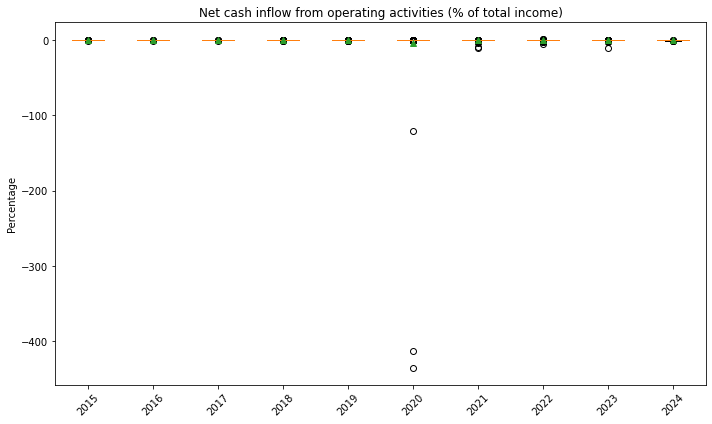

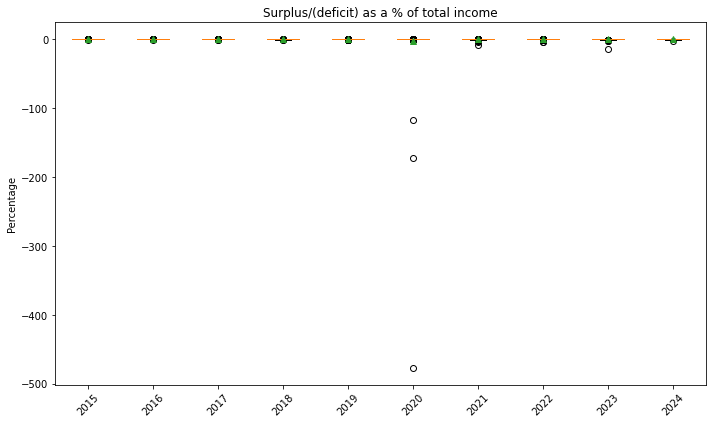

In [41]:
# add visualisation of our two key data columns in boxplots, and investigate outliers

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

df_boxplot = df_pivot

# Extract the starting year from 'Academic Year' and convert to numeric
df_boxplot['Academic Year'] = df_boxplot['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(int)

kfi_column = "Net cash inflow from operating activities as a % of total income"

years = sorted(df_boxplot["Academic Year"].unique())

cash_data_by_year = [
    df_boxplot.loc[df_boxplot["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.boxplot(
    cash_data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Net cash inflow from operating activities (% of total income)")

plt.tight_layout()
plt.show()

kfi_column = "Surplus/(deficit) as a % of total income"

sd_data_by_year = [
    df_boxplot.loc[df_boxplot["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.boxplot(
    sd_data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Surplus/(deficit) as a % of total income")

plt.tight_layout()
plt.show()



In [47]:
# let's look at the outliers

# filter out other columns
df_pivot_filtered = df_pivot.filter([
    'UKPRN', 'HE provider', 'Country of HE provider', 'Academic Year',
    'Region of HE provider',
    'Net cash inflow from operating activities as a % of total income',
    'Surplus/(deficit) as a % of total income'
], axis=1)

outlier_col_net_cash = "Net cash inflow from operating activities as a % of total income - Outlier"
outlier_col_surplus  = "Surplus/(deficit) as a % of total income - Outlier"

df_pivot_filtered[outlier_col_net_cash] = False
df_pivot_filtered[outlier_col_surplus]  = False

#  Outliers for 'Net cash inflow from operating activities as a % of total income' 
column_net_cash = 'Net cash inflow from operating activities as a % of total income'

s = df_pivot_filtered[column_net_cash]

if not s.dropna().empty:
    upper_threshold_net_cash = np.percentile(s.dropna(), 95)
    lower_threshold_net_cash = np.percentile(s.dropna(), 5)

    # True if BELOW 5th percentile OR ABOVE 95th percentile
    df_pivot_filtered[outlier_col_net_cash] = (s < lower_threshold_net_cash) | (s > upper_threshold_net_cash)
else:
    print(f"Warning: '{column_net_cash}' column is empty or all NaN after initial filtering.")

# Check if DataFrame is empty after the first filter
if df_pivot_filtered.empty:
    print("DataFrame became empty after filtering 'Net cash inflow from operating activities as a % of total income'. No further filtering applied.")
else:
    #  Filter for 'Surplus/(deficit) as a % of total income' 
    column_surplus_deficit = 'Surplus/(deficit) as a % of total income'

    s = df_pivot_filtered[column_surplus_deficit]

    # Ensure there's data to calculate percentiles from
    if not s.dropna().empty:
        # Calculate 95th and 5th percentiles from the current state of the DataFrame
        upper_threshold_surplus = np.percentile(s.dropna(), 95)
        lower_threshold_surplus = np.percentile(s.dropna(), 5)

        # Filter the DataFrame to remove values outside these bounds
        df_pivot_filtered[outlier_col_surplus] = (s < lower_threshold_surplus) | (s > upper_threshold_surplus)

    else:
        print(f"Warning: '{column_surplus_deficit}' column is empty or all NaN after previous filtering. Skipping this filter step.")

df_pivot_filtered["Outlying value"] = (df_pivot_filtered["Net cash inflow from operating activities as a % of total income - Outlier"] | df_pivot_filtered["Surplus/(deficit) as a % of total income - Outlier"])

df_outliers = df_pivot_filtered[df_pivot_filtered['Outlying value'] == True]

display(df_outliers)

df_pivot_filtered.to_csv('processed_table-14-pivot-highlight-outliers.csv', index=False) # save the cleaned file without its index

print('Pivoted dataframe saved to processed_table-14-pivot-highlight-outliers.csv')

KFI ratio title,UKPRN,HE provider,Country of HE provider,Academic Year,Region of HE provider,Net cash inflow from operating activities as a % of total income,Surplus/(deficit) as a % of total income,Net cash inflow from operating activities as a % of total income - Outlier,Surplus/(deficit) as a % of total income - Outlier,Outlying value
9,10000216,All Nations Christian College Limited,England,2021,East of England,0.056,0.263,False,True,True
11,10000216,All Nations Christian College Limited,England,2023,East of England,0.178,-0.334,False,True,True
39,10000571,Bath Spa University,England,2015,South West,0.351,0.120,True,False,True
54,10000712,University College Birmingham,England,2021,West Midlands,0.263,0.039,True,False,True
75,10000894,Bristol Baptist College,England,2018,South West,-0.380,-0.112,True,False,True
...,...,...,...,...,...,...,...,...,...,...
2184,10086359,Caspian School of Academics,England,2023,London,0.593,0.209,True,False,True
2185,10086591,Regent's University London Limited,England,2020,London,-0.256,0.083,True,False,True
2190,10088214,S P Jain London School of Management Limited,England,2023,South East,-10.502,-14.117,True,True,True
2191,10089591,Walbrook Institute London Limited,England,2023,London,-0.321,-0.388,True,True,True


Pivoted dataframe saved to processed_table-14-pivot-highlight-outliers.csv


C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


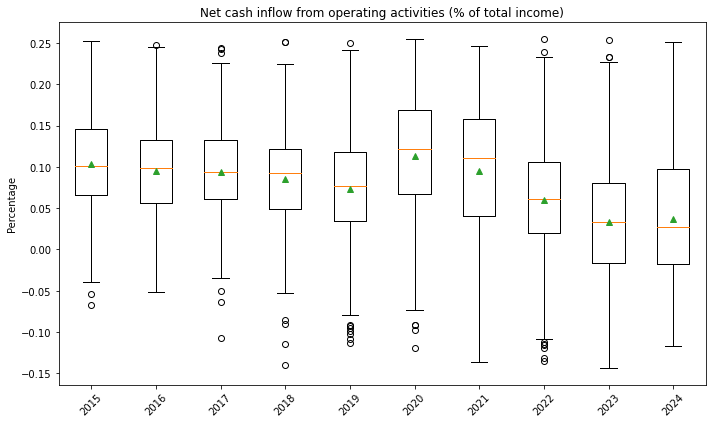

In [36]:
# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(int)

kfi_column = "Net cash inflow from operating activities as a % of total income"

years = sorted(df_excl_outliers["Academic Year"].unique())

data_by_year = [
    df_excl_outliers.loc[df_excl_outliers["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.boxplot(
    data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Net cash inflow from operating activities (% of total income)")

plt.tight_layout()
plt.show()


C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


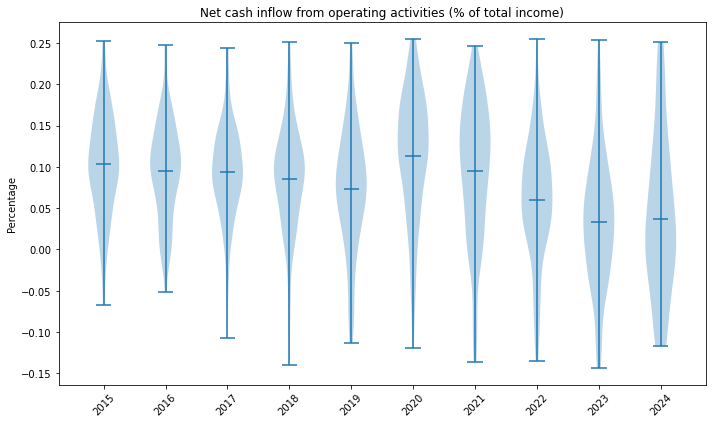

In [37]:
# visualise as violin plot

# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(int)

kfi_column = "Net cash inflow from operating activities as a % of total income"

years = sorted(df_excl_outliers["Academic Year"].unique())

data_by_year = [
    df_excl_outliers.loc[df_excl_outliers["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.violinplot(
    data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Net cash inflow from operating activities (% of total income)")

plt.tight_layout()
plt.show()


C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


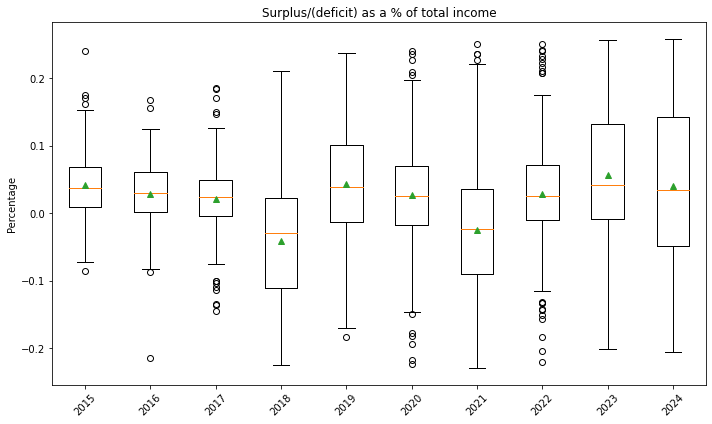

In [48]:
# visualise s/d as boxplot

# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(int)

kfi_column = "Surplus/(deficit) as a % of total income"

years = sorted(df_excl_outliers["Academic Year"].unique())

data_by_year = [
    df_excl_outliers.loc[df_excl_outliers["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.boxplot(
    data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Surplus/(deficit) as a % of total income")

plt.tight_layout()
plt.show()


C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


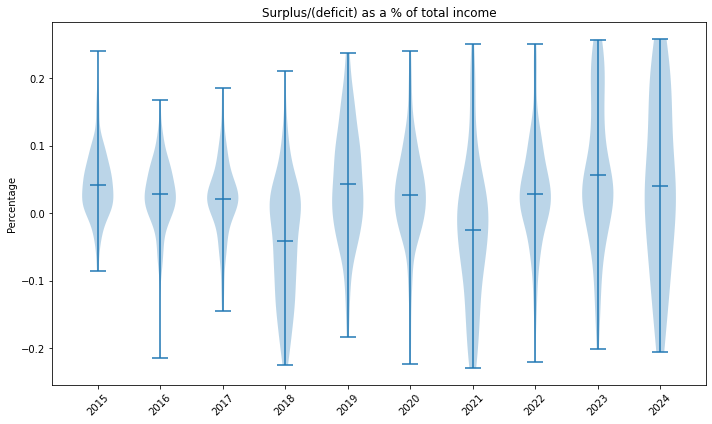

In [49]:
# visualise as violin plot

# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(int)

kfi_column = "Surplus/(deficit) as a % of total income"

years = sorted(df_excl_outliers["Academic Year"].unique())

data_by_year = [
    df_excl_outliers.loc[df_excl_outliers["Academic Year"] == year, kfi_column].dropna()
    for year in years]

plt.figure(figsize=(10, 6))

plt.violinplot(
    data_by_year,
    showmeans=True,
    #showmedians=True
)

plt.xticks(
    ticks=range(1, len(years) + 1),
    labels=years,
    rotation=45
)

plt.ylabel("Percentage")
plt.title("Surplus/(deficit) as a % of total income")

plt.tight_layout()
plt.show()


C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\u

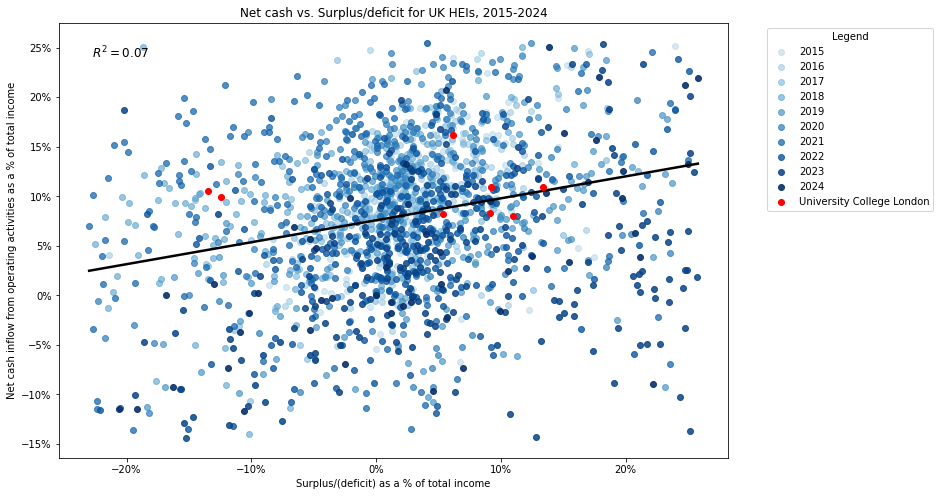

In [100]:
# plot a scattergraph of these two KFIs against each other

import matplotlib.ticker as mticker

# import methods to use different colours
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a darker section of the colour map to avoid 2015 becoming invisible in the scatter plot

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )

# clean data to remove any records where either value is a string/blank/NaN etc

x_col = 'Surplus/(deficit) as a % of total income'
y_col = 'Net cash inflow from operating activities as a % of total income'

tmp = df_excl_outliers[[x_col, y_col]].copy()

# Force numeric (turns bad strings into NaN)
tmp[x_col] = pd.to_numeric(tmp[x_col], errors='coerce')
tmp[y_col] = pd.to_numeric(tmp[y_col], errors='coerce')

# Drop rows where either value is missing or non-finite
tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()

x = tmp[x_col].to_numpy()
y = tmp[y_col].to_numpy()

plt.figure(figsize=(12, 8))

# Create a normalisation for years
years = sorted(df_excl_outliers["Academic Year"].dropna().astype(int).unique())

# create a mask to separate the UCL datapoints
ucl_mask = df_excl_outliers["HE provider"].eq("University College London")

norm = mcolors.Normalize(vmin=min(years), vmax=max(years))
cmap = truncate_colormap(cm.Blues, minval=0.35, maxval=1.0)

alpha_min = 0.45
alpha_max = 0.90

# plot datapoints on graph using a loop to plot each year in a different shade

for year in years:
    year_mask = (df_excl_outliers["Academic Year"].astype(int) == year) & (~ucl_mask)
    year_data = tmp[year_mask]

    alpha = alpha_min + (alpha_max - alpha_min) * norm(year)


    plt.scatter(
        year_data[x_col],
        year_data[y_col],
        color=cmap(norm(year)),
        alpha=alpha,
        label=year
    )

# Plot the UCL datapoints separately in red
    
ucl_data = tmp[ucl_mask]
plt.scatter(
    ucl_data[x_col],
    ucl_data[y_col],
    color="red",
    alpha=1.0,
    label="University College London",
    zorder=5
)
    
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# xseq is a nice smooth set of x-values to draw the regression line across
xseq = np.linspace(x.min(), x.max(), 100)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)

# R2 calculation
r = np.corrcoef(x, y)[0, 1]
r2 = r ** 2

# Add R2 text 
plt.text(
    0.05, 0.95,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)

# NB: R2 tells you how much of what you see in Y can be explained by X.
# In this case: How much of the variation in net cash can be explained by surplus/deficit?
# It ranges from 0.00 (The line explains nothing) to 1.00 (the line explains everything)
# 25% would indicate some relationship, but a lot of noise
# 50% : about half the variation in Y is explained by X
# etc.


# Formatting and lables

ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals = 0))

plt.title('Net cash vs. Surplus/deficit for UK HEIs, 2015-2024')
plt.ylabel('Net cash inflow from operating activities as a % of total income')
plt.xlabel('Surplus/(deficit) as a % of total income')

plt.legend(
    title="Legend",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.show()

C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


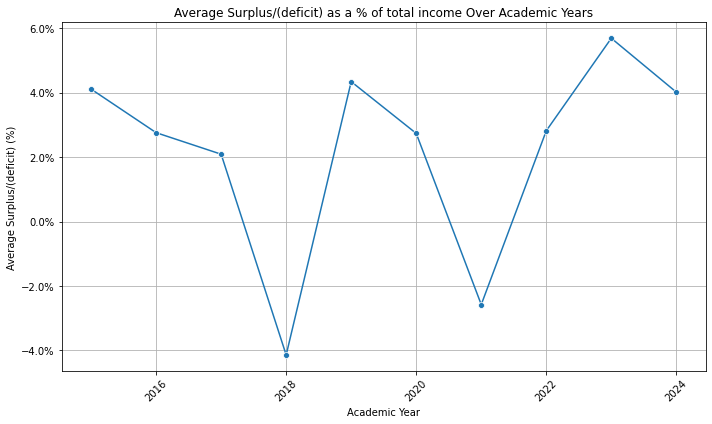

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
# Assuming format like 'YYYY/YY' or 'YYYY-YYYY'
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(float)

# Calculate the mean 'Surplus/(deficit) as a % of total income' per academic year
average_surplus_by_year = df_excl_outliers.groupby('Academic Year')['Surplus/(deficit) as a % of total income'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Academic Year', y='Surplus/(deficit) as a % of total income', data=average_surplus_by_year, marker='o')

# Format y-axis to display as percentages
formatter = mticker.PercentFormatter(xmax=1.0) # Values are already decimals (e.g., 0.05 for 5%)
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average Surplus/(deficit) as a % of total income Over Academic Years')
plt.xlabel('Academic Year')
plt.ylabel('Average Surplus/(deficit) (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()